# Predikcija stope nasilnog kriminala

Cilj projekta je izgradnja i poređenje modela za predikciju stope nasilnog kriminala u 
lokalnim zajednicama na osnovu dostupnih socio-ekonomskih i demografskih 
karakteristika. Podaci sadrže velik broj ulaznih promenljivih koje opisuju populaciju, 
obrazovanje,  zaposlenost,  strukturu  domaćinstava,  prihode,  stanovanje  i  policijske 
resurse, dok su izlazne varijable povezane sa kriminalitetom. 

**Ciljevi projekta** su:
* izgradnja i evaluacija modela za predikciju ciljne varijable na tabelarnim podacima sa velikim brojem obeležja i nedostajućim vrednostima, 
* poređenje naprednih regresionih algoritama  nad  istim  protokolom  obrade podataka, 
* robustnost modela na autlajere i šum, 
* analiza značaja obeležja i interpretabilnost radi identifikacije  faktora koji najviše doprinose predikciji.

## 0) Setup

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

REPO = Path(".").resolve()
DATA_PATH = REPO / "data" / "CommViolPredUnnormalizedData.txt"
CSV_DIR = REPO / "results" / "csv"
PLOT_DIR = REPO / "results" / "plots"

print("DATA:", DATA_PATH.exists(), DATA_PATH)
print("CSV :", CSV_DIR.exists(), CSV_DIR)
print("PLOT:", PLOT_DIR.exists(), PLOT_DIR)

DATA: True C:\Users\korisnik\Desktop\FAKULTET\2. GODINA\NUMERICKI SOFTVER\PROJEKAT\implementacija\PROJEKAT_NANS\data\CommViolPredUnnormalizedData.txt
CSV : True C:\Users\korisnik\Desktop\FAKULTET\2. GODINA\NUMERICKI SOFTVER\PROJEKAT\implementacija\PROJEKAT_NANS\results\csv
PLOT: True C:\Users\korisnik\Desktop\FAKULTET\2. GODINA\NUMERICKI SOFTVER\PROJEKAT\implementacija\PROJEKAT_NANS\results\plots


## 1) Skup podataka

Skup podataka koji se analizira i nad kojim će se primenjivati regresioni modeli je **Communities and Crime (Unnormalized)** skup podataka sa UCI Machine Learning Repository.
Skup podataka sadrži podatke o 2215  redova  (lokalne  zajednice)  i  obuhvata  147 kolona (atributa).
Kolona čiju vrednost želimo da predvidimo je **violentPerPop**,  koja  predstavlja stopu nasilnog kriminala po glavi stanovnika.

In [2]:
from src.data.make_dataset import load_dataset, prepare_dataframe, TARGET, ID_COLS, LEAKAGE_COLS

df_raw = load_dataset(DATA_PATH)
print("RAW shape:", df_raw.shape)

df = prepare_dataframe(df_raw)
print("Prepared shape:", df.shape)
print("TARGET:", TARGET)

print("ID_COLS:", ID_COLS)
print("LEAKAGE_COLS:", len(LEAKAGE_COLS))
df.head()

RAW shape: (2215, 147)
Prepared shape: (1994, 126)
TARGET: violentPerPop
ID_COLS: ['communityname', 'countyCode', 'communityCode', 'fold']
LEAKAGE_COLS: 17


,State,pop,perHoush,pctBlack,pctWhite,pctAsian,pctHisp,pct12-21,pct12-29,pct16-24,...,landArea,popDensity,pctUsePubTrans,policCarsAvail,policOperBudget,pctPolicPatrol,gangUnit,pctOfficDrugUnit,policBudgetPerPop,violentPerPop
0,NJ,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,...,6.5,1845.9,9.63,NaN,NaN,NaN,NaN,0.0,NaN,41.02
1,PA,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,...,10.6,2186.7,3.84,NaN,NaN,NaN,NaN,0.0,NaN,127.56
2,OR,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,...,10.6,2780.9,4.37,NaN,NaN,NaN,NaN,0.0,NaN,218.59
3,NY,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,...,5.2,3217.7,3.31,NaN,NaN,NaN,NaN,0.0,NaN,306.64
5,MO,140494,2.45,2.51,95.65,0.90,0.95,18.09,32.89,20.04,...,70.4,1995.7,0.97,NaN,NaN,NaN,NaN,0.0,NaN,442.95


- Raw skup: 2215 redova i 147 kolona.
- Nakon uklanjanja ID kolona (4) i leakage kolona (17), dobijamo 147 − 21 = 126 atributa.
- Nakon izbacivanja redova gde nedostaje target (`violentPerPop`), ostaje 1994 redova (uklonjeno 221 red).

## 2) Pretprocesiranje

Prvi korak u realizaciji projekta predstavlja pretprocesiranje podataka iz skupa 
Communities and Crime (unnormalized). Skup podataka sadrži nedostajuće vrednosti koje 
su označene simbolom `?`, kao i atribute sa različitim skalama i značajnim rasponom 
vrednosti.

U okviru pretprocesiranja biće sprovedeni sledeći koraci: 
- zamena simboličkih oznaka nedostajućih vrednosti `?` odgovarajućim numeričkim oznakama
- izbacivanje atributa sa velikim procentom nedostajućih vrednosti (>80% missing)
- imputacija preostalih nedostajućih vrednosti
- kodiranje kategorijske promenljive `state` (one-hot za linearne modele; za CatBoost ostaje kategorijska)
- uklanjanje  potencijalnih leakage atributa vezanih za kriminal (sve “crime” kolone osim ciljne)
- skaliranje obeležja tamo gde je potrebno (StandardScaler / RobustScaler - linearni modeli i regularizacija)

Interpolacija se ne koristi, budući da redovi u skupu podataka ne poseduju prirodan redosled, te interpolirane vrednosti ne bi imale statističko niti semantičko značenje. Radi se median imputacija kao baseline, uz poređenje sa KNN/MICE imputacijom.

* `Median`: Za svaku kolonu koja ima nedostajuće vrednosti, svih postojećih podataka i njome se popune praznine.
* `KNN`: Traži najsličnijih *k* redova (suseda) onom redu u kojem podatak nedostaje. Gleda vrednosti u drugim kolonama da bi odredio ko je "sličan". Zatim uzima prosek ili medijanu vrednosti tih *k* suseda da popuni rupu.
* `MICE`: Posmatra svaku kolonu sa nedostajućim podacima kao "metu", a ostale kolone kao "prediktore". On bukvalno trenira seriju regresionih modela da predvidi svaku nedostajuću vrednost. Proces se ponavlja više puta (u krug) dok se vrednosti ne stabilizuju.

In [3]:
missing_ratio = df_raw.isna().mean().sort_values(ascending=False)
thr = 0.80
cols_over_thr = missing_ratio[missing_ratio > thr]
print("Broj kolona sa missing >", thr, "=", len(cols_over_thr))
cols_over_thr.to_frame("missing_ratio").head(30)

Broj kolona sa missing > 0.8 = 22


,missing_ratio
pctPolicBlack,0.845147
policCallPerOffic,0.845147
policePerPop2,0.845147
policCarsAvail,0.845147
policOperBudget,0.845147
pctPolicPatrol,0.845147
policAveOT,0.845147
gangUnit,0.845147
policBudgetPerPop,0.845147
pctPolicWhite,0.845147


In [4]:
from src.data.preprocess import DropHighMissing

dropper = DropHighMissing(threshold=0.80, target=TARGET)
dropper.fit(df_raw)
drop_list = dropper.to_drop_

print("DropHighMissing (threshold=0.80) izbacuje", len(drop_list), "kolone.")
drop_list[:30]
pd.DataFrame({"dropped_col": drop_list}).head(30)

DropHighMissing (threshold=0.80) izbacuje 22 kolone.


,dropped_col
0,numPolice
1,policePerPop
2,policeField
3,policeFieldPerPop
4,policeCalls
5,policCallPerPop
6,policCallPerOffic
7,policePerPop2
8,racialMatch
9,pctPolicWhite


* Kolone sa >80% missing su uglavnom policijski/patrol atributi…
* One se uklanjaju jer imputacija na tako velikom procentu missing-a može da uvede šum

In [5]:
from src.data.preprocess import build_preprocessor_linear, build_preprocessor_catboost

pre_lin = build_preprocessor_linear(df, imputer="median", scaler="standard", missing_threshold=0.80)
pre_cb  = build_preprocessor_catboost(df, imputer="median", missing_threshold=0.80)

pre_lin

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('drop_target', ...), ('drop_high_missing', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function bui...00225FF7000E0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword ar

In [6]:
pre_cb

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('drop_target', ...), ('drop_high_missing', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function bui...00225FF700180>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword ar

**Preprocessor za linearne modele (`pre_lin`)** je definisan kao scikit-learn Pipeline:
- prvo izbacuje target kolonu (`violentPerPop`) iz ulaza (sprečavanje leakage),
- zatim izbacuje kolone sa >80% missing,
- potom kroz `ColumnTransformer` odvaja numeričke i kategorijske kolone:
  - numeričke: imputacija (median/KNN/MICE) + skaliranje (Standard/Robust),
  - kategorijske (npr. `State`): imputacija najčešćom vrednošću + One-Hot encoding.

**Preprocessor za CatBoost (`pre_cb`)** zadržava kategorijske feature-e u izvornom obliku i radi imputaciju
u DataFrame formatu, što je pogodno za CatBoost.

## 3) Linearni modeli

### Bazni regresioni model (OLS)
OLS je referentni (baseline) model. Testiramo dve varijante:
- bez skaliranja
- sa standardizacijom (z-score)

Pored metrika (RMSE/MAE/R²), analiziramo i numeričku stabilnost dizajn matrice:
- rank (da li je matrica punog ranga)
- najmanju singularnu vrednost
- condition number (velike vrednosti ukazuju na multikolinearnost i nestabilne koeficijente)

In [7]:
df_ols = pd.read_csv(CSV_DIR / "ols_diagnostics.csv")
df_ols

,variant,rank,s_min,cond,n_features
0,OLS_median_none,144,3.594320e-12,3.351541e+18,146
1,OLS_median_standard,144,9.341005e-15,1.817914e+16,146


**Tumačenje:** ako je `rank < n_features` i condition number ekstremno velik (npr. 10^16–10^18),
OLS rešenje je numerički nestabilno zbog multikolinearnosti. To je glavni motiv za Ridge/Lasso/ElasticNet.

## Regularizovani linearni modeli (Ridge / Lasso / ElasticNet)

Kod OLS smo videli numeričku nestabilnost zbog multikolinearnosti (rank < broj feature-a i veliki condition number).
Zato uvodimo regularizaciju:

- **Ridge (L2):** dodaje kaznu $\lambda \sum_{i=1}^{n} \beta_i^2$ → stabilizuje koeficijente.
- **Lasso (L1):** dodaje kaznu $\lambda \sum_{i=1}^{n} |\beta_i|$ → može da postavi neke koeficijente na 0 (selekcija feature-a).
- **ElasticNet (L1 + L2):** kombinacija Ridge i Lasso → korisno kada postoje grupe korelisanih obeležja.

Hiperparametri se biraju pomoću **GridSearchCV u k-fold cross-validation** na trening skupu.

In [8]:
df_lin = pd.read_csv(CSV_DIR / "results_linear_baselines.csv")
cols = ["name","imputer","scaler","is_tuned","cv_rmse","val_rmse","val_r2","test_rmse","test_r2"]
top = df_lin.sort_values(["val_rmse","test_rmse"]).reset_index(drop=True)[cols].copy()

top["cv_rmse"] = top["cv_rmse"].round(3)
top["val_rmse"] = top["val_rmse"].round(3)
top["test_rmse"] = top["test_rmse"].round(3)
top["val_r2"] = top["val_r2"].round(4)
top["test_r2"] = top["test_r2"].round(4)

display(top.head(10))

,name,imputer,scaler,is_tuned,cv_rmse,val_rmse,val_r2,test_rmse,test_r2
0,"ElasticNet(a=0.01,l1=0.5)",mice,standard,False,370.541,398.378,0.6573,354.500,0.6389
1,"ElasticNet(a=0.01,l1=0.5)",median,standard,False,370.527,398.390,0.6573,354.534,0.6388
2,"ElasticNet(a=0.01,l1=0.5)",knn,standard,False,370.497,398.411,0.6572,354.586,0.6387
3,Ridge(alpha=1),mice,standard,False,366.435,400.529,0.6536,360.570,0.6264
4,Ridge(alpha=1),median,standard,False,366.417,400.543,0.6535,360.599,0.6264
5,Ridge(alpha=1),knn,standard,False,366.378,400.566,0.6535,360.643,0.6263
6,"ElasticNet(a=0.01,l1=0.5)",mice,robust,False,370.415,401.029,0.6527,361.763,0.6239
7,"ElasticNet(a=0.01,l1=0.5)",median,robust,False,370.400,401.042,0.6527,361.797,0.6239
8,"ElasticNet(a=0.01,l1=0.5)",knn,robust,False,370.370,401.065,0.6526,361.848,0.6238
9,Ridge(alpha=1),mice,robust,False,367.044,401.642,0.6516,362.865,0.6217


Ova tabela prikazuje **TOP 10 kombinacija** (model + preprocesiranje) iz eksperimenta sa linearnim modelima,
sortiranih po **najmanjem `val_rmse`** (a zatim `test_rmse`).

Kolone znače:
- **name** – naziv modela (OLS, Ridge, Lasso, ElasticNet; “tuned” znači da su hiperparametri birani GridSearchCV-om)
- **imputer** – metoda imputacije missing vrednosti (median / KNN / MICE)
- **scaler** – skaliranje numeričkih atributa (none / standard / robust)
- **is_tuned** – da li je model podešavan (tuning) ili fiksna konfiguracija
- **cv_rmse** – prosečan RMSE na k-fold cross-validation na trening skupu
- **val_rmse / val_r2** – performanse na validacionom skupu (koristimo za izbor najboljeg modela)
- **test_rmse / test_r2** – performanse na test skupu (finalna procena generalizacije)

Ovo nam omogućava da uporedimo uticaj imputacije i skaliranja, kao i razliku između baznih i regularizovanih modela.

In [9]:
df_tuned = df_lin[df_lin["is_tuned"].astype(str).str.lower() == "true"].copy()
df_tuned = df_tuned.sort_values(["cv_rmse", "val_rmse", "test_rmse"]).reset_index(drop=True)

df_tuned_view = df_tuned.copy()
df_tuned_view["best_params"] = (
    df_tuned_view["best_params"].astype(str)
    .str.replace("np.float64", "", regex=False)
)

df_tuned_view[["name","imputer","scaler","cv_rmse","val_rmse","val_r2","test_rmse","test_r2","best_params"]]

,name,imputer,scaler,cv_rmse,val_rmse,val_r2,test_rmse,test_r2,best_params
0,Lasso (tuned),mice,standard,364.293361,402.136089,0.650784,364.241344,0.618778,{'model__alpha': (0.0610540229658533)}
1,ElasticNet (tuned),mice,standard,364.355449,402.817878,0.649599,366.151529,0.614769,"{'model__alpha': (0.001), 'model__l1_ratio': 0.9}"
2,Ridge (tuned),mice,standard,364.396356,403.309163,0.648743,367.256137,0.612441,{'model__alpha': (0.0517947467923121)}


Prikazani su najbolji hiperparametri dobijeni GridSearchCV-om (k-fold CV na trening skupu) za Ridge, Lasso i ElasticNet.

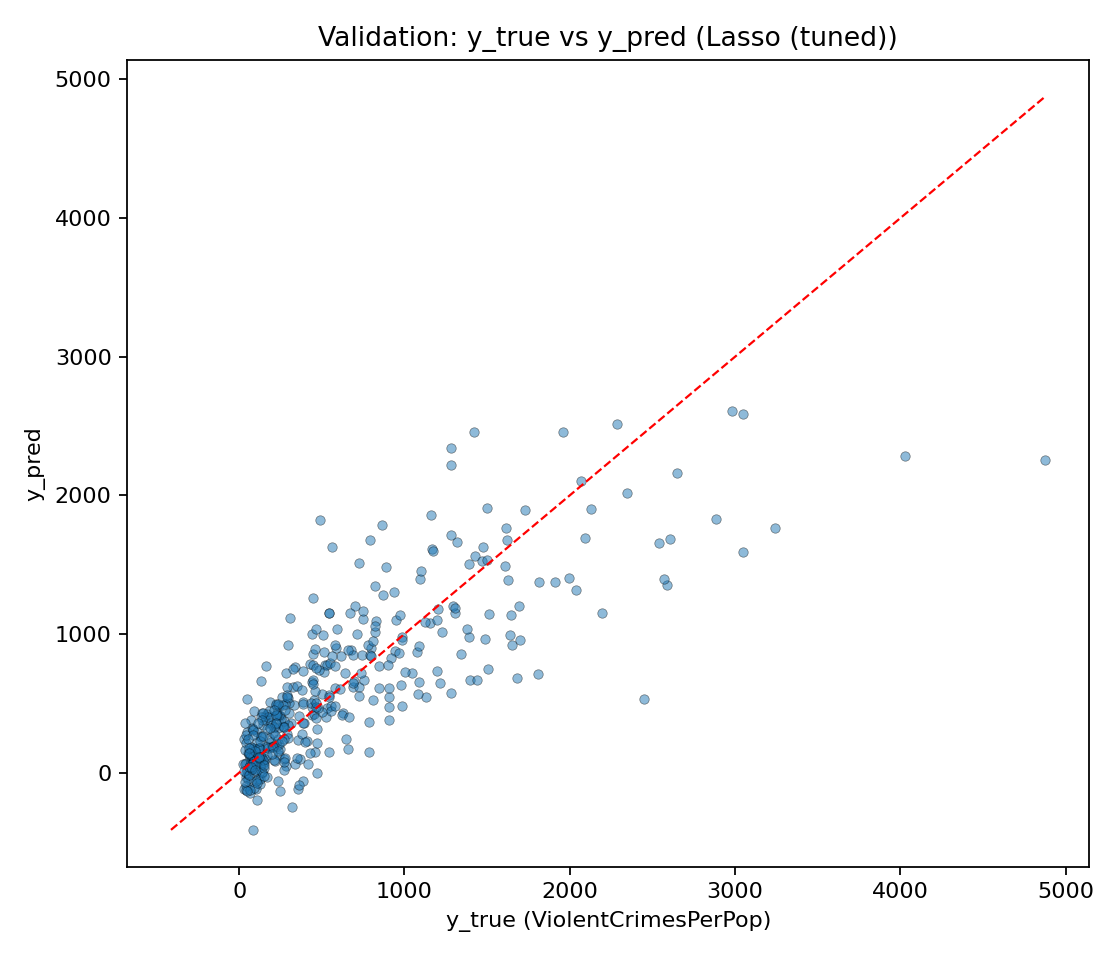

In [10]:
p = PLOT_DIR / "baseline_pred_vs_true_val.png"
display(Image.open(p))

Grafikon prikazuje odnos `y_true` i `y_pred` na validacionom skupu za najbolji regularizovani linearni model.
Tačke blizu dijagonale označavaju dobre predikcije, dok odstupanja i outlieri ukazuju na teške primere
(u višim vrednostima kriminala linearni model teže prati nelinearnosti).

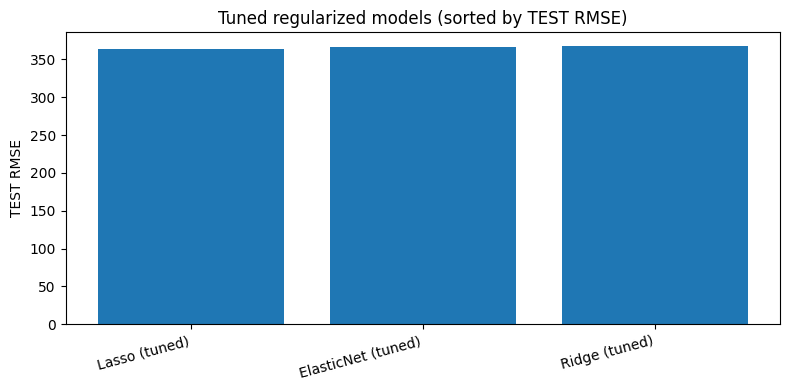

In [11]:
d = df_tuned_view.sort_values("test_rmse")

plt.figure(figsize=(8,4))
plt.bar(d["name"], d["test_rmse"])
plt.ylabel("TEST RMSE")
plt.title("Tuned regularized models (sorted by TEST RMSE)")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

**Zaključak:** Regularizovani modeli smanjuju uticaj multikolinearnosti i daju stabilnije procene.
Ridge obično najbolje stabilizuje kada postoji mnogo korelisanih feature-a, dok Lasso uvodi sparsity.
ElasticNet je kompromis i često radi dobro kada postoji “grupna” korelacija.